# An exploration of Bitcoin block sizes and proposed block size limits

To run this Jupyter notebook interactively, you need
- Python 2.7 or 3.4
- Jupyter
- Matplotlib
- Seaborn
- Pandas
- Humanize

On Debian/Ubuntu, you can run
```
sudo apt-get install python3-matplotlib python3-pandas python3-pip
sudo pip install jupyter seaborn humanize
jupyter notebook
```

In [1]:
from __future__ import unicode_literals, print_function
%matplotlib inline
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from humanize import naturalsize
plt.rcParams['figure.figsize'] = 12, 12

Helper for plotting the block size scale on the Y axis:

In [2]:
def plot_yticks(ax, low, high, unit=1e6):
    bases = range(int(math.log2(low)), int(math.log2(high)) + 1)
    ax.set_yticks([float(2 ** n) * unit for n in bases])
    ax.set_yticklabels([naturalsize(2 ** n * unit) for n in bases])

Limit plots to year 2037:

In [3]:
last_date = pd.Timestamp('2037-01-01')

The `blocksizes.csv` file is created using Rusty Russell's [bitcoin-iterate](https://github.com/rustyrussell/bitcoin-iterate) tool. [Download](https://github.com/rustyrussell/bitcoin-iterate/archive/master.zip), compile with `make` and run on a computer which has the complete blockchain as downloaded by `bitcoind`:

    wget https://github.com/rustyrussell/bitcoin-iterate/archive/master.zip
    unzip master
    cd bitcoin-iterate-master
    make
    ./bitcoin-iterate -q --block='%bs,%bN,%bl,%bc' >blocksizes.csv
    
Once you have `blocksizes.csv`, place it in the same directory with this notebook.

## Sizes of mined blocks until now

Read `blocksizes.csv` and assign names to columns.

Convert the `time` column from Unix epoch to Pandas timestamps and use it as the index.

In [4]:
csv_data = pd.read_csv('blocksizes.csv',
                       names=['time', 'height', 'size', 'transactions'],
                       dtype=int)
timestamps = pd.to_datetime(csv_data.time, unit='s')
csv_data.time = timestamps
csv_data.set_index('time', inplace=True)
csv_data.describe().astype(int)

,height,size,transactions
count,372937,372937,372937
mean,186468,118316,220
std,107657,191564,358
min,0,176,1
25%,93234,474,2
50%,186468,28793,59
75%,279702,163650,302
max,372936,1000000,12239


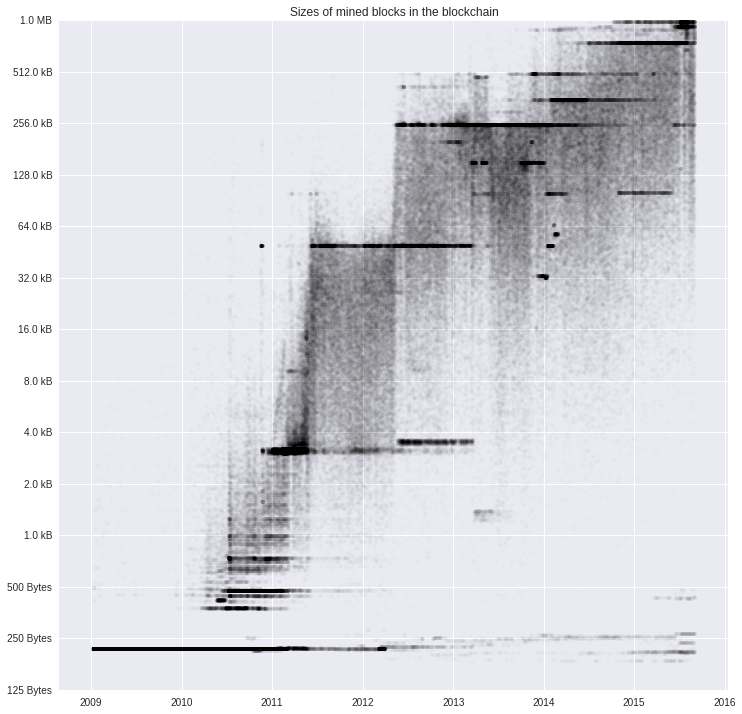

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(csv_data.index, csv_data['size'], alpha=0.01, lw=0.001, color='black')
plt.yscale('log')
plt.ylim(0, 1000000)
plot_yticks(ax, 0.1, 1024, 1000)
plt.title('Sizes of mined blocks in the blockchain');

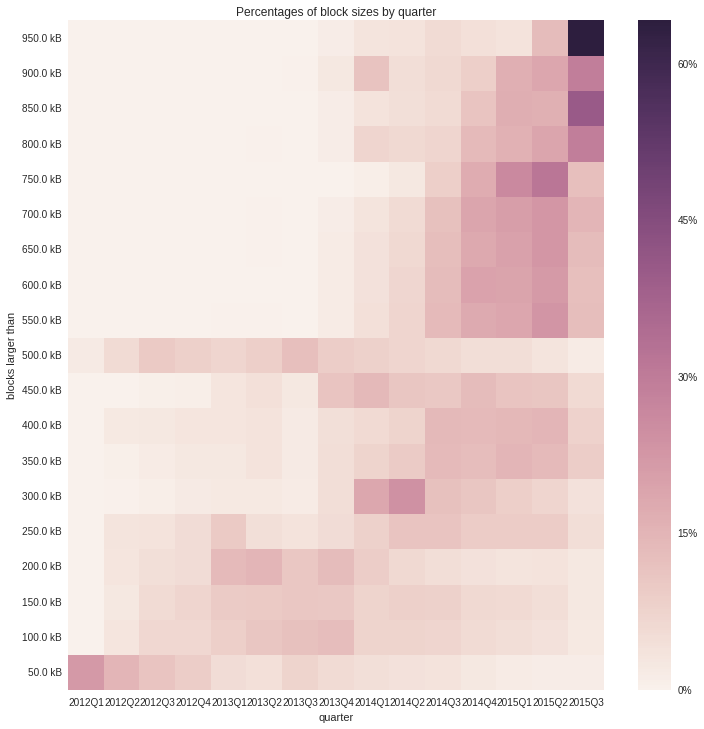

In [6]:
data = csv_data['2012-01-01':]
size_bins = range(0, 1000000, 50000)
size_freqs = pd.cut(data['size'], size_bins)
ct = pd.crosstab(size_freqs, 
                 data.index.to_period('Q'),
                 colnames=['quarter'],
                 rownames=['blocks larger than']).apply(lambda r: 100*r/r.sum(), axis=1)
sns.heatmap(ct[::-1], 
            xticklabels=ct.columns,
            yticklabels=[naturalsize(b) for b in size_bins[:0:-1]],
            cbar_kws={'format': '%.0f%%'})
plt.title('Percentages of block sizes by quarter');

## BIP 100

- http://gtf.org/garzik/bitcoin/BIP100-blocksizechangeproposal.pdf
- https://bitcoinmagazine.com/21747/closer-look-bip100-block-size-proposal-bitcoin-miners-rallying-behind/

Calculate estimated block interval based on 5000 last blocks:

In [7]:
block_interval = timestamps.iloc[-5000:].diff().mean().round('s')
block_freq = pd.DateOffset(seconds=block_interval.total_seconds())
future_start = timestamps.iloc[-1] + block_freq
print('Block interval estimated at {} starting from next block {}'
      .format(block_freq._offset, future_start))

Block interval estimated at 0:09:41 starting from next block 2015-09-04 05:26:29


Both BIP 100 and BIP 101 would be effective 11 January 2016.

In [8]:
fork_date = '2016-01-11'

With BIP 100, the block size limit may change every 12000 blocks. The change can be at most double and at least half of the previous block size limit, and the new limit may never fall below 1 MB nor exceed 32 MB.

In [9]:
def make_bip100():
    freq = 12000 * block_freq
    periods = 6
    index = (pd.date_range(fork_date, periods=periods, freq=freq)
             .insert(periods, last_date))
    steps = [2 ** min(n, periods - 1) * 1e6 for n in range(periods + 1)]
    first = pd.Series(steps, index)
    last = pd.Series(steps, index + freq - block_freq)
    high = first.combine_first(last)
    bip100 = pd.DataFrame({'high': high})
    bip100['low'] = 1e6
    return bip100

bip100 = make_bip100()
bip100

,high,low
2016-01-11 00:00:00,1000000,1000000
2016-03-31 16:30:19,1000000,1000000
2016-03-31 16:40:00,2000000,1000000
2016-06-20 09:10:19,2000000,1000000
2016-06-20 09:20:00,4000000,1000000
2016-09-09 01:50:19,4000000,1000000
2016-09-09 02:00:00,8000000,1000000
2016-11-28 18:30:19,8000000,1000000
2016-11-28 18:40:00,16000000,1000000
2017-02-17 11:10:19,16000000,1000000


Plot two scenarios under the BIP 100 rules:
- smallest possible block size limit (always 1 MB)
- biggest possible block size limit (always doubles, reaches 32 MB)

In [10]:
def plot_bip100(data):
    plt.fill_between(data.index, data['high'], data['low'], alpha=.1)
    plt.plot(data.index, data.low, label='BIP 100 low')
    plt.plot(data.index, data.high, label='BIP 100 high')
    return ax

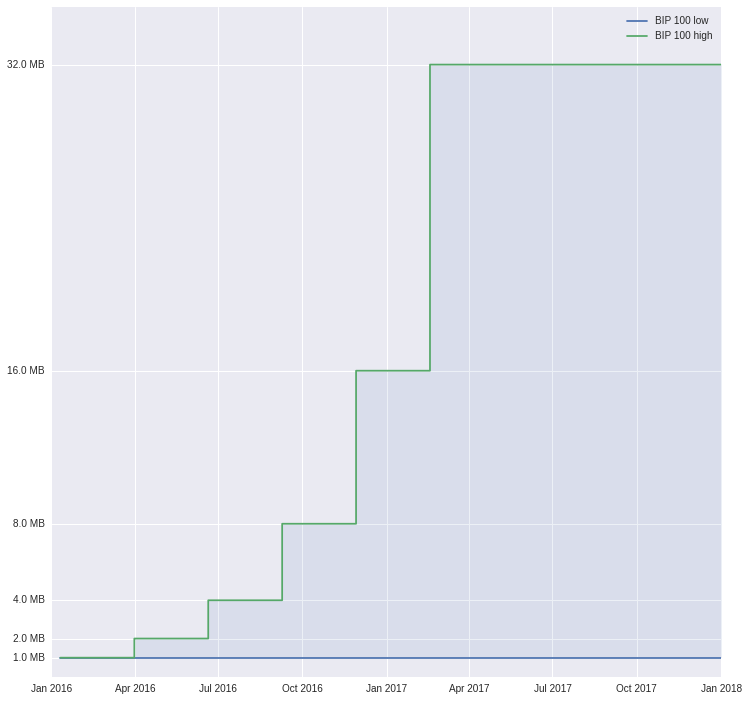

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_bip100(bip100)
plt.xlim('2016', '2018')
plot_yticks(ax, 1, 32)
plt.legend()

## BIP 101

In [12]:
bip101_periods = 11
bip101_index = (pd.date_range(fork_date, periods=bip101_periods, freq='730d')
                .insert(bip101_periods, last_date))
bip101 = pd.Series([2 ** min(n, bip101_periods - 1) * 8 * 1e6 for n in range(bip101_periods + 1)],
                   bip101_index)

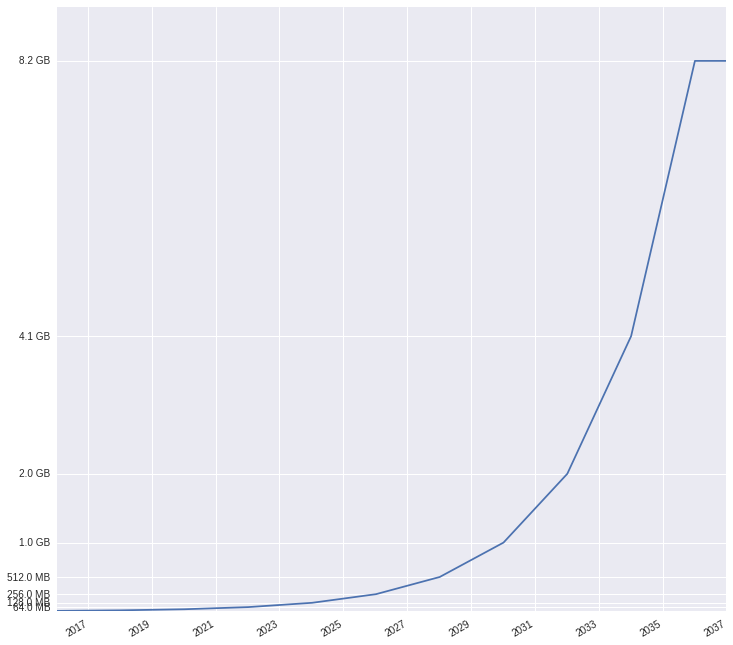

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
bip101.plot()
plot_yticks(ax, 64, 8192)

## Comparing BIP 100 and BIP 101

(735974.0, 743635.0)

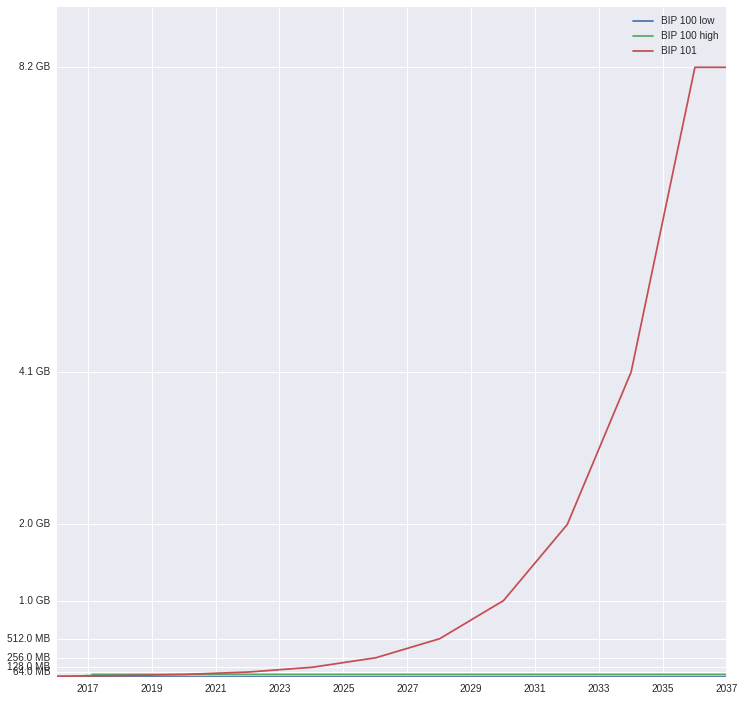

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
period = 'd'
high = csv_data.resample(period, how='max')
plot_bip100(make_bip100())
plt.plot(bip101.index, bip101.values, label='BIP 101')
plt.legend()
plot_yticks(ax, 64, 8192)
#high['bip101'] = high['bip101'].interpolate()
#mean = csv_data.resample(period, fill_method='ffill')
#plt.fill_between(mean.index, mean['bip100_high'], mean['bip100_low'], color='lightblue')
#plt.plot(high.index, high['bip101'].interpolate(), color='black', label='BIP 101 block size limit')
#plt.yscale('log')
#plt.ylim(0, 1e9)
plt.xlim(fork_date, last_date)
#plt.ylabel('bytes')
#plt.xlabel('time')
#plt.legend()

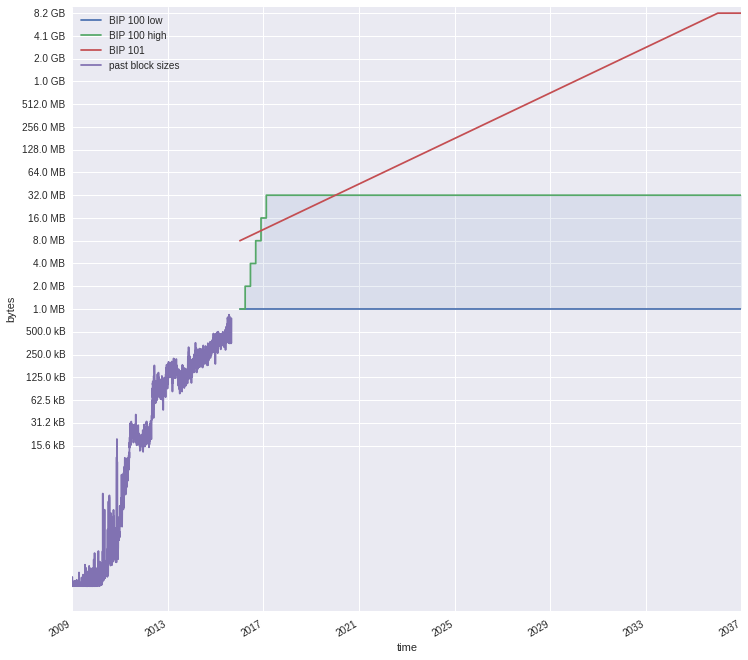

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
period = 'd'
high = csv_data.resample(period, how='max')
plot_bip100(make_bip100())
plt.plot(bip101.index, bip101.values, label='BIP 101')
past = csv_data['size'].resample(period, fill_method='ffill')
past.plot(label='past block sizes')
plt.yscale('log')
plt.xlim('2009', last_date)
plt.ylabel('bytes')
plt.xlabel('time')
plot_yticks(ax, 0.01, 8192)
plt.legend(loc='upper left')